In [1]:
%load_ext autoreload
%autoreload 2

from omegaconf import OmegaConf

OmegaConf.register_new_resolver(
    "relpath", lambda p: str(Path('/disk/scratch2/nkudryas/BAND-torch/notebooks/').parent / p)
)

import os
os.environ["CUDA_VISIBLE_DEVICES"]= "6"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from sklearn.linear_model import Ridge 
from sklearn.decomposition import PCA
import os

from lfads_torch.post_run.band_analysis import run_posterior_sampling

In [ ]:
dataset_name = 'multitasks_20140725'
PATH = '/disk/scratch2/nkudryas/BAND-torch/datasets'

model_titles = ["LFADS", "BAND"]

bin_size_ms = 20
bin_width_sec = bin_size_ms / 1000  

In [11]:
dataset_name = 'multitasks_tgt_onset_20140725'
model_conf_name = 'multitask'
fac_dim = 20
encod_seq_len = 50
model_names = [f'{model_name}_{fac_dim}f_{model_conf_name}' for model_name in ['lfads','band']]

best_model_dest = f"/disk/scratch2/nkudryas/BAND-torch/runs/pbt-multitasks/{dataset_name}"
model_dests = [f"{best_model_dest}/{mn}/best_model/" for mn in model_names]
# models = [BAND(model_dir=model_dest) for model_dest in model_dests]

In [12]:
model_dests

['/disk/scratch2/nkudryas/BAND-torch/runs/pbt-multitasks/multitasks_tgt_onset_20140725/lfads_20f_multitask/best_model/',
 '/disk/scratch2/nkudryas/BAND-torch/runs/pbt-multitasks/multitasks_tgt_onset_20140725/band_20f_multitask/best_model/']

In [ ]:
import torch
from hydra.utils import instantiate
from pathlib import Path
import hydra

from lfads_torch.band_utils import flatten


overrides={
        "datamodule": dataset_name,
        "model": model_conf_name, #+'_st'
        "model.fac_dim": fac_dim,
        "model.encod_seq_len": encod_seq_len,
        "model.recon_seq_len": encod_seq_len,
    }
config_path="../../configs/pbt.yaml"
print(config_path)

# Compose the train config with properly formatted overrides
config_path = Path(config_path)
overrides = [f"{k}={v}" for k, v in flatten(overrides).items()]
with hydra.initialize(
    config_path=config_path.parent,
    job_name="get_weights",
    version_base="1.1",
):
    config = hydra.compose(config_name=config_path.name, overrides=overrides)

# Instantiate `LightningDataModule` and `LightningModule`
datamodule = instantiate(config.datamodule, _convert_="all")
model = instantiate(config.model)

# check the latest checkpoint
from glob import glob
checkpoint_folders = glob(model_dests[1]+'/checkpoint*')

ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
# f'{model_dests[1]}/lightning_checkpoints/last.ckpt'
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

../../configs/pbt.yaml


<All keys matched successfully>

In [43]:
# dir(model.behavior_readout)
model.readout[0].weight

Parameter containing:
tensor([[ 0.1121,  0.1566, -0.2162,  ...,  0.0552, -0.0576, -0.2850],
        [ 0.4060,  0.4211, -0.0221,  ...,  0.0494, -0.1470,  0.0313],
        [ 0.3563,  0.4391,  0.0097,  ...,  0.2210, -0.1150,  0.0887],
        ...,
        [-0.1182, -0.0015, -0.1668,  ...,  0.0153,  0.0175,  0.0340],
        [ 0.0849, -0.0138, -0.0940,  ...,  0.0844, -0.0194, -0.0486],
        [ 0.1167,  0.3307, -0.1361,  ...,  0.1272, -0.3356,  0.4596]],
       requires_grad=True)

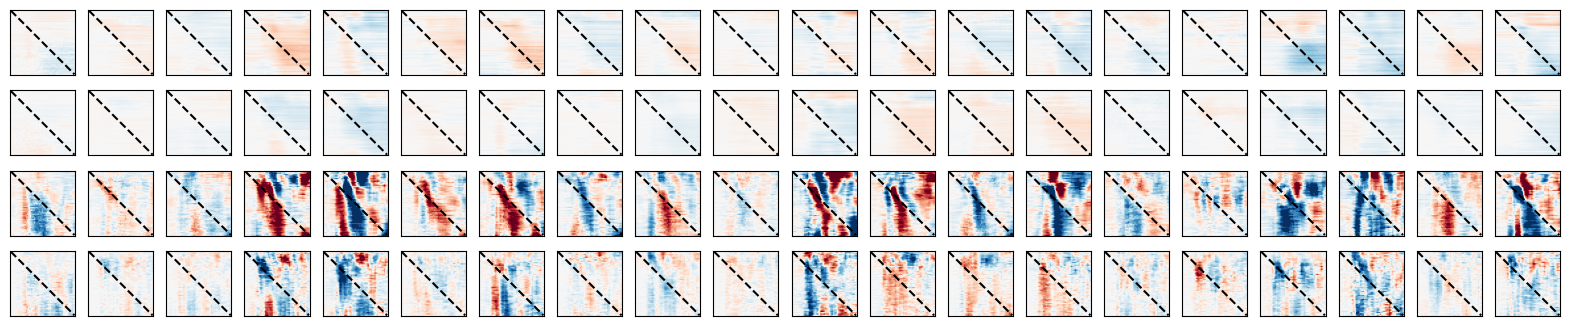

In [17]:
seq_len = config.model.recon_seq_len
in_features = config.model.behavior_readout.in_features
out_features = config.model.behavior_readout.out_features
beh_W = model.behavior_readout.layers[2].weight.T

assert beh_W.shape == (in_features*seq_len, out_features*seq_len)

beh_W = beh_W.reshape((seq_len, in_features, seq_len, out_features))

r = torch.std(beh_W)*4
fig, ax = plt.subplots(out_features, in_features, figsize=(in_features, out_features))
for j in range(in_features):
    for i in range(out_features):
        # r = torch.std(beh_W[...,i])*4
        ax[i,j].imshow(beh_W[:,j,:,i].detach().numpy(), cmap='RdBu', vmin=-r, vmax=r)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        # diagonal
        ax[i,j].plot([0,seq_len-1],[0,seq_len-1], 'k--')

# Run on test

In [32]:
dataset_filename = Path(PATH) / 'multitasks_20140725.h5'

with h5py.File(dataset_filename, 'r') as f:
    train_data = f['train_recon_data'][:]
    valid_data = f['valid_recon_data'][:]
    train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
    valid_epoch = f["valid_epoch"][:]
    true_train_beh = f['train_behavior'][:]
    true_valid_beh = f['valid_behavior'][:]
    true_target_direction = f['valid_target_direction'][:]

In [25]:
def merge_train_valid(train_data, valid_data, train_inds, valid_inds):
    n_samples = len(train_data) + len(valid_data)
    merged_data = np.full((n_samples, *train_data.shape[1:]), np.nan)
    merged_data[train_inds] = train_data
    merged_data[valid_inds] = valid_data
    return merged_data

# Get the paths to all data files
both_factors = []
both_controls = []
both_control_means = []
both_control_stds = []
both_rates = []
both_ics = []
both_behaviors = []
lin_decoded_behs = []
seq2seq_decoded_behs = []
control_decoded_behs = []
ridge_models_0_lag = []
for model_name in model_names:

    data_path = os.path.join(best_model_dest,model_name,'best_model','lfads_output_20140725.h5')
    bin_width_sec = 0.01 # chewie
    # Data is binned at 10 ms
    with h5py.File(data_path) as f:
        print(f.keys())
        # Merge train and valid data for factors and rates
        train_inds, valid_inds = f["train_inds"][:], f["valid_inds"][:]
        factors = f["valid_factors"][:]
        rates = f["valid_output_params"][:] / bin_width_sec
        behavior = f["valid_output_behavior_params"][:]
        controls = f['valid_gen_inputs'][:]
        ic = f['valid_gen_init'][:]
        control_mean = f['valid_co_means'][:]
        control_stds = f['valid_co_stds'][:]

        train_factors = f["train_factors"][:]
        train_controls = f['train_gen_inputs'][:]
        train_ic = f['train_gen_init'][:]

    # load ablated
    data_path = os.path.join(best_model_dest,model_name,'best_model','lfads_W_ablated_output_20140725.h5')
    with h5py.File(data_path) as f:
        noci_factors = f["valid_factors"][:]
        
    
    # train Ridge regression to predict behavior from factors (0lag)
    X_train = train_factors.reshape(-1,train_factors.shape[-1])
    Y_train = true_train_beh.reshape(-1,true_train_beh.shape[-1])
    X_test = factors.reshape(-1,factors.shape[-1])
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_0lag = ridge.predict(X_test).reshape(true_valid_beh.shape)
    ridge_models_0_lag.append(ridge)

    # Ridge seq2seq
    X_train = train_factors.reshape(train_factors.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = factors.reshape(factors.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_seq2seq = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge from control inputs (seq2seq)
    X_train = train_controls.reshape(train_controls.shape[0],-1)
    Y_train = true_train_beh.reshape(true_train_beh.shape[0],-1)
    X_test = controls.reshape(controls.shape[0],-1)
    ridge = Ridge(alpha=1).fit(X_train, Y_train)
    Y_pred_control = ridge.predict(X_test).reshape(true_valid_beh.shape)

    # Ridge decode residuals


    # PCA on initial conditions
    pca = PCA(n_components=2)
    pca.fit(train_ic)
    ic_pca = pca.transform(ic)
    print(train_ic.shape,ic_pca.shape)
            
    both_factors.append(factors)
    both_controls.append(controls)
    both_control_means.append(control_mean)
    both_control_stds.append(control_stds)
    both_rates.append(rates)
    both_ics.append(ic_pca)
    both_behaviors.append(behavior)
    lin_decoded_behs.append(Y_pred_0lag)
    seq2seq_decoded_behs.append(Y_pred_seq2seq)
    control_decoded_behs.append(Y_pred_control)

<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_force', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_ic_mean', 'train_ic_std', 'train_inds', 'train_output_behavior_params', 'train_output_params', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_co_means', 'valid_co_stds', 'valid_con_states', 'valid_encod_data', 'valid_epoch', 'valid_factors', 'valid_force', 'valid_gen_init', 'valid_gen_inputs', 'valid_gen_states', 'valid_ic_mean', 'valid_ic_std', 'valid_inds', 'valid_output_behavior_params', 'valid_output_params', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>
(767, 200) (192, 2)
<KeysViewHDF5 ['train_behavior', 'train_co_means', 'train_co_stds', 'train_con_states', 'train_encod_data', 'train_epoch', 'train_factors', 'train_force', 'train_gen_init', 'train_gen_inputs', 'train_gen_states', 'train_

## compute co-bps

In [28]:
from scipy.stats import poisson
valid_mean_count = valid_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(valid_data, valid_mean_count)
n_sp = valid_data.sum()

valid_LL = {'LFADS': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[0]), 
            'BAND': poisson.logpmf(valid_data, (bin_size_ms / 1000) * both_rates[1])}
valid_co_bps = {key: np.sum(valid_LL[key] - base_LL)/(n_sp * np.log(2)) for key in valid_LL.keys()}
valid_co_bps

{'LFADS': -0.18003862888544467, 'BAND': -0.15362016697673753}

In [29]:
# train co-bps
train_mean_count = train_data.mean(0).mean(0) # to get Hz -> x100
base_LL = poisson.logpmf(train_data, train_mean_count)
n_sp = train_data.sum()

train_LL = {'LFADS': poisson.logpmf(train_data, (bin_size_ms / 1000) * both_train_rates[0]),
            'BAND': poisson.logpmf(train_data, (bin_size_ms / 1000) * both_train_rates[1])}
train_co_bps = {key: np.sum(train_LL[key] - base_LL)/(n_sp * np.log(2)) for key in train_LL.keys()}
train_co_bps

IndexError: list index out of range

In [22]:
# logistic regression to decode reach direction
from sklearn.linear_model import LogisticRegression

#from ICs
for train_ics, ics in zip(both_train_ics, both_ics):
    X_train = train_ics
    Y_train = true_train_target_direction
    X_test = ics
    log_reg = LogisticRegression(max_iter=1000).fit(X_train, Y_train)
    Y_pred = log_reg.predict(X_test)
    print(f"Logistic regression accuracy: {np.mean(Y_pred == true_target_direction)}")


#from factors
for train_f, f in zip(both_train_factors, both_factors):
    X_train = train_f.reshape(train_f.shape[0],-1)
    Y_train = true_train_target_direction
    X_test = f.reshape(f.shape[0],-1)
    log_reg = LogisticRegression(max_iter=1000).fit(X_train, Y_train)
    Y_pred = log_reg.predict(X_test)
    print(f"Logistic regression accuracy: {np.mean(Y_pred == true_target_direction)}")

Logistic regression accuracy: 0.24870848708487084
Logistic regression accuracy: 0.2966789667896679
Logistic regression accuracy: 0.25092250922509224
Logistic regression accuracy: 0.31365313653136534


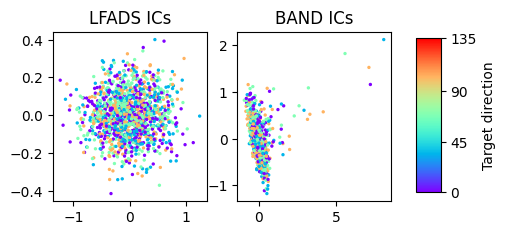

In [19]:
# substitute elements with ids
uniq_dirs = np.unique(true_target_direction)
true_label = np.array([np.where(uniq_dirs==t)[0][0] for t in true_target_direction])

from matplotlib import cm
trial_id = 0
fig, ax = plt.subplots(1,2, figsize=(5,2.2))
for i in range(2):
        ax[i].set_title(model_titles[i] + ' ICs')
        ax[i].scatter(*both_ics[i].T,c=cm.rainbow(true_label/4),
                      s=2)
# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cbar = fig.colorbar(cm.ScalarMappable(cmap='rainbow'), cax=cbar_ax)
cbar.set_ticks([0,.33,.66,1])
cbar.set_ticklabels(['0','45','90','135'])
cbar.set_label('Target direction')


In [20]:
valid_epoch

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 1.106e+03, 1.106e+03,
       1.106e+03])

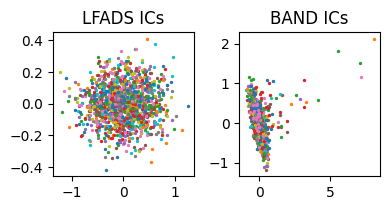

In [47]:
from matplotlib import cm
trial_id = 0
fig, ax = plt.subplots(1,2, figsize=(4,2.2))
for i in range(2):
    for epoch in np.unique(valid_epoch):
        ax[i].set_title(model_titles[i] + ' ICs')
        ax[i].scatter(*both_ics[i][valid_epoch==epoch].T,c=f"C{int(epoch)}",s=2)
fig.tight_layout()

In [48]:
valid_epoch

array([1.000e+00, 1.000e+00, 1.000e+00, ..., 1.106e+03, 1.106e+03,
       1.106e+03])

51.0


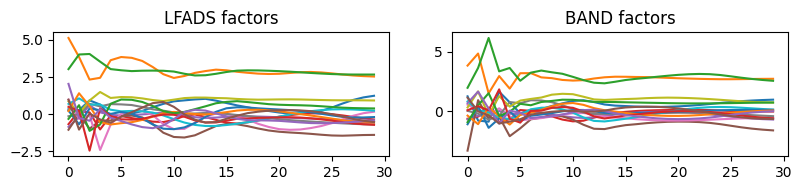

In [33]:
trial_id = 100
print(valid_epoch[trial_id])
fig, ax = plt.subplots(1,2, figsize=(8,2)) #,sharey='row')
for i in range(2):
    ax[i].plot(both_factors[i][trial_id]) # - both_factors[i][trial_id].mean(0))
    ax[i].set_title(model_titles[i] + ' factors')
fig.tight_layout()

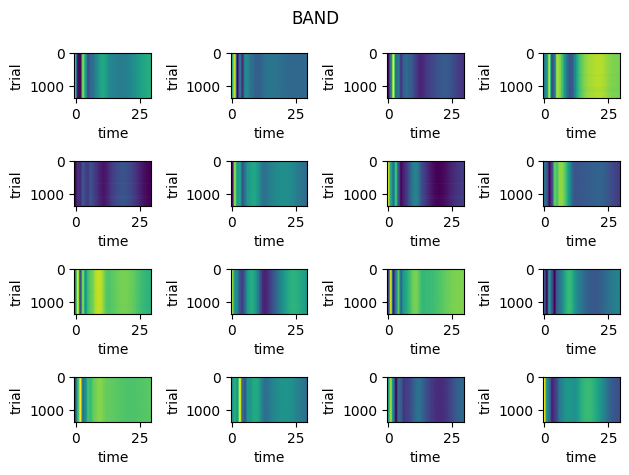

In [46]:
fig, axes = plt.subplots(4,4)

for i,ax in enumerate(axes.flatten()):
    ax.imshow(both_factors[1][:,:,i],aspect='auto')
    ax.set_xlabel('time')
    ax.set_ylabel('trial')

plt.suptitle('BAND')
plt.tight_layout()


In [50]:
# trial_id = 1
# print(valid_epoch[trial_id])
# fig, ax = plt.subplots(4,2, figsize=(8,8)) #,sharey='row')
# for i in range(2):
#     ax[1,i].plot(both_controls[i][trial_id])
#     ax[2,i].plot(both_control_means[i][trial_id])
#     ax[3,i].plot(both_control_stds[i][trial_id])
#     ax[0,i].set_title(model_titles[i] + ' factors')
#     ax[1,i].set_title(model_titles[i] + ' controls')
#     ax[2,i].set_title(model_titles[i] + ' control means')
#     ax[3,i].set_title(model_titles[i] + ' control stds')
# fig.tight_layout()

## Sample single trajectories

In [51]:
for i,model_name in enumerate(['lfads','band']):
    # check the latest checkpoint
    checkpoint_folders = glob(model_dests[i]+'/checkpoint*')

    ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    model.eval()

    for s in range(5):
        filename = f'/{model_name}_sample{s}.h5' # ends up saving in current folder no matter what
        run_posterior_sampling(model, datamodule, filename, num_samples=1)

KeyboardInterrupt: 

In [57]:
for i,model_name in enumerate(['lfads','band']):
    # check the latest checkpoint
    checkpoint_folders = glob(model_dests[i]+'/checkpoint*')

    ckpt_path = checkpoint_folders[-1] + '/tune.ckpt'
    model.load_state_dict(torch.load(ckpt_path)["state_dict"])

    model.eval()
    B = torch.zeros_like(model.decoder.rnn.cell.co_linear.bias)
    B[len(B) // 2:] = -20 # making variance exp(-10)
    model.decoder.rnn.cell.co_linear.weight = torch.nn.Parameter(torch.zeros_like(model.decoder.rnn.cell.co_linear.weight))
    model.decoder.rnn.cell.co_linear.bias = torch.nn.Parameter(B)

    for s in range(5):
        filename = f'/{model_name}_abl_sample{s}.h5' # ends up saving in current folder no matter what
        run_posterior_sampling(model, datamodule, filename, num_samples=1)


100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


In [51]:
# Get the paths to all data files
trial_id=1
both_factors = []
both_behaviors = []
both_controls = []
for i,model_name in enumerate(['lfads','lfads_abl','band','band_abl']):
    factors, behavior, controls = [], [], []
    for s in range(5):
        data_path = f'{model_name}_sample{s}_sess0.h5'
        # Data is binned at 10 ms
        with h5py.File(data_path) as f:
            factors.append(f["valid_factors"][:])
            beh = ridge_models_0_lag[i//2].predict(f["valid_factors"][:].reshape(-1,f["valid_factors"][:].shape[-1])).reshape(true_valid_beh.shape)
            behavior.append(beh)
            controls.append(f['valid_gen_inputs'][:])

    both_factors.append(factors)
    both_behaviors.append(behavior)
    both_controls.append(controls)

both_behaviors = np.array(both_behaviors)
both_factors = np.array(both_factors)
both_controls = np.array(both_controls)

# # plot the factors
# fig, ax = plt.subplots(1,2, figsize=(8,4),sharex=True,sharey=True)
# for i in range(2):
#     for s in range(3):
#         ax[i].plot(*both_behaviors[i][s][trial_id].T)
#         ax[i].set_title(model_titles[i] + f' behavior')
#     ax[i].plot(*true_valid_beh[trial_id].T)
# fig.tight_layout()


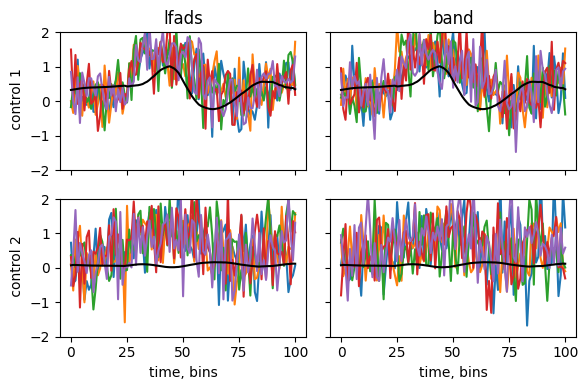

In [52]:
# plot the factors
trial_id=0
fig, ax = plt.subplots(2,2, figsize=(6,4),sharex=True,sharey=True)
for i,model_name in enumerate(['lfads','band']):
    for j,j_name in enumerate(['1','2']):
        for s in range(5):
            ax[j,i].plot(both_controls[2*i][s][trial_id][...,j])
        ax[j,i].plot(both_control_means[i][trial_id][...,j],c='k')
        if j ==0:
            ax[j,i].set_title(model_name)
        else:
            ax[j,i].set_xlabel('time, bins')
        if i==0:
            ax[j,i].set_ylabel(f' control {j_name}')
        # ax[j,i].set_ylim([-2,6])
        ax[j,i].set_ylim([-2,2])
fig.tight_layout()

In [53]:
np.where(valid_epoch==1)

(array([  0,   1,   2,   4,   5,  11,  12,  13,  17,  18,  20,  33,  34,
         36,  42,  44,  46,  48,  49,  50,  54,  55,  64,  69,  71,  72,
         73,  75,  77,  83,  84,  89,  91,  94,  95,  99, 100, 106, 107,
        113]),)

In [54]:
def R2(pred_beh,true_beh):
    return (1 - np.sum((pred_beh - true_beh)**2) / np.sum((true_beh - np.mean(true_beh))**2)) * 100

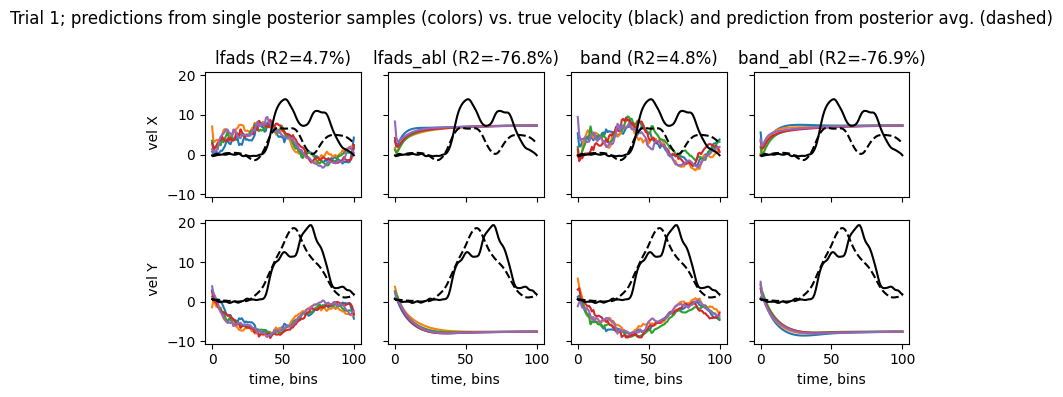

In [55]:
# plot the factors
trial_id=1
fig, ax = plt.subplots(2,4, figsize=(8,4),sharex=True,sharey=True)
fig.suptitle(f'Trial {trial_id}; predictions from single posterior samples (colors) vs. true velocity (black) and prediction from posterior avg. (dashed)')
for i,model_name in enumerate(['lfads','lfads_abl','band','band_abl']):
    for j,j_name in enumerate(['X','Y']):
        for s in range(5):
            ax[j,i].plot(both_behaviors[i][s][trial_id][...,j])
        # r2 = R2(both_behaviors[i,:,trial_id].reshape(-1,2),
        #         np.repeat(np.expand_dims(true_valid_beh[trial_id],axis=0),5,axis=0).reshape(-1,2))
        r2 = R2(both_behaviors[i,:,:].reshape(-1,2),
                np.repeat(np.expand_dims(true_valid_beh,axis=0),5,axis=0).reshape(-1,2))
        if j ==0:
            ax[j,i].set_title(model_name + f' (R2={r2:.1f}%)')
        else:
            ax[j,i].set_xlabel('time, bins')
        if i==0:
            ax[j,i].set_ylabel(f' vel {j_name}')
        ax[j,i].plot(true_valid_beh[trial_id][...,j],c='k')
        # r2 = R2(seq2seq_decoded_behs[i],true_valid_beh)
        ax[j,i].plot(seq2seq_decoded_behs[i//2][trial_id][...,j],c='k',ls='--')
fig.tight_layout()

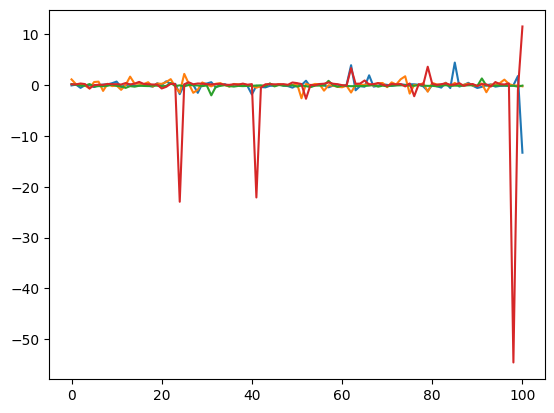

In [184]:
co_post = model.co_prior.make_posterior(torch.Tensor(both_control_means[1][trial_id]),
                                        torch.Tensor(both_control_stds[1][trial_id]))
con_output = co_post.rsample().numpy()
plt.plot(con_output)

In [154]:
# p_train.gen_inputs.shape
# both_behaviors[0].shape, true_valid_beh.shape

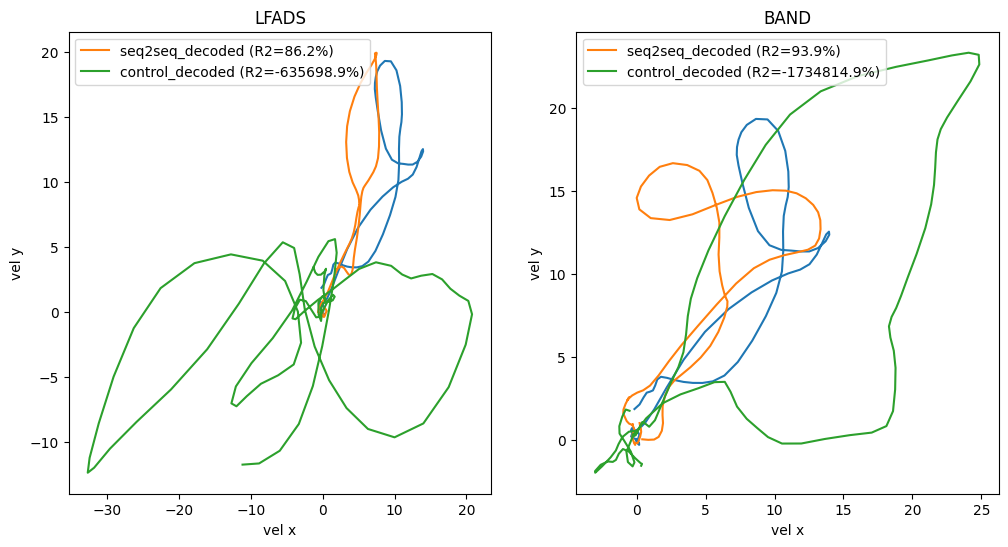

In [155]:
fig,axes = plt.subplots(1,2, figsize=(12,6))
trial_id = 1
axes[0].plot(*true_valid_beh[trial_id].T)
axes[1].plot(*true_valid_beh[trial_id].T)
for i in range(len(both_behaviors)):
    # axes[i].plot(*both_behaviors[i][trial_id].T, label=f'model_output (R2={R2(both_behaviors[i],true_valid_beh):.1f}%)')
    # axes[i].plot(*lin_decoded_behs[i][trial_id].T, label=f'lin_decoded (R2={R2(lin_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*seq2seq_decoded_behs[i][trial_id].T, label=f'seq2seq_decoded (R2={R2(seq2seq_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].plot(*control_decoded_behs[i][trial_id].T, label=f'control_decoded (R2={R2(control_decoded_behs[i],true_valid_beh):.1f}%)')
    axes[i].set_xlabel('vel x')
    axes[i].set_ylabel('vel y')
    axes[i].set_title(model_titles[i])
    axes[i].legend()


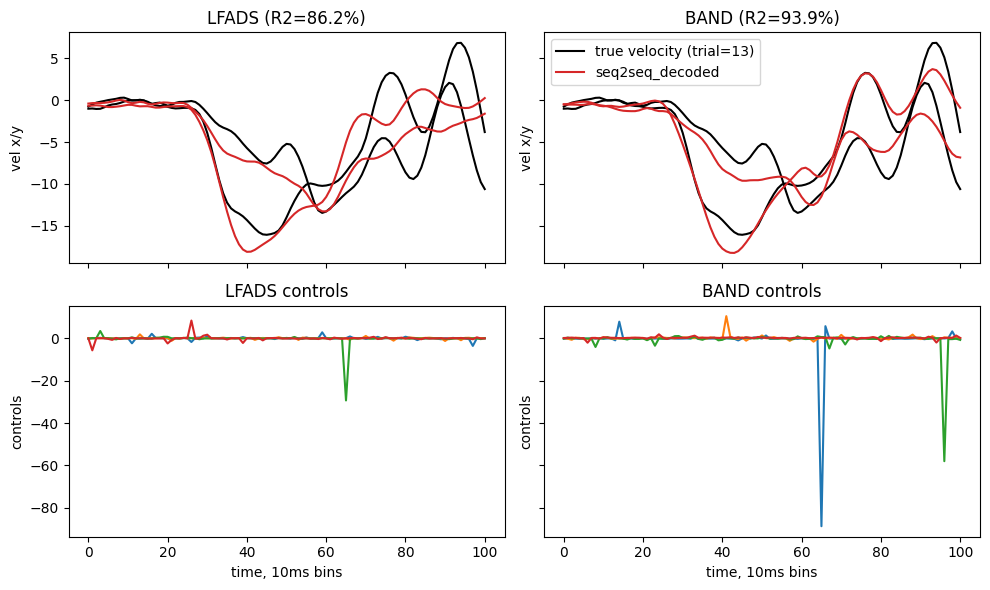

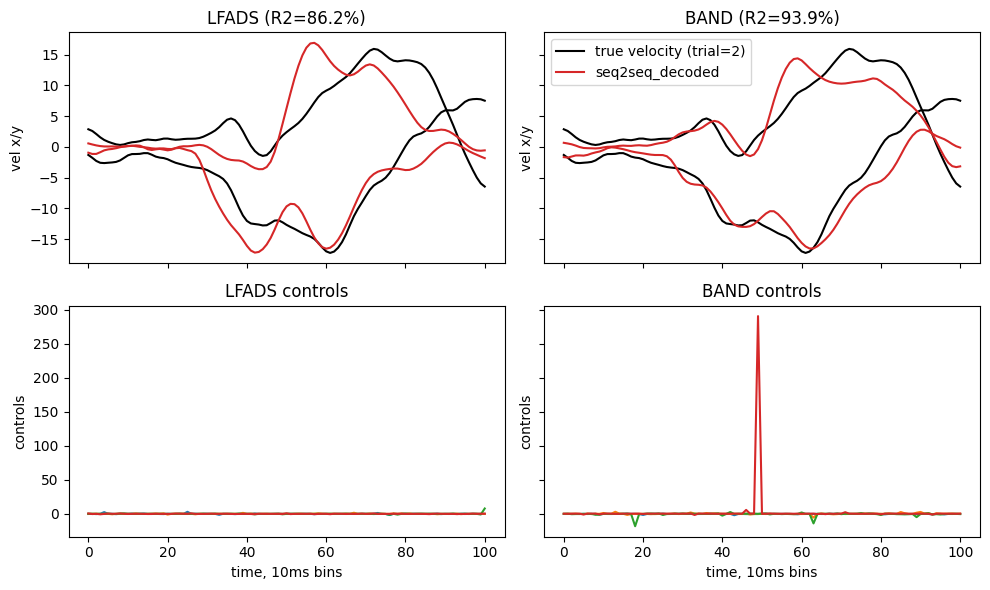

In [156]:
for trial_id in [13,2]:
    fig,axes = plt.subplots(2,2, figsize=(10,6), sharey='row', sharex=True)
    axes[0,0].plot(true_valid_beh[trial_id],c='k')
    axes[0,1].plot(true_valid_beh[trial_id],c='k',label=(f'true velocity (trial={trial_id})',None))
    for i in range(len(lin_decoded_behs)):
        # if i==1:
            # axes[0,i].plot(both_behaviors[i][trial_id], label=('model_output',None))
        # axes[i].plot(lin_decoded_behs[i][trial_id], label='lin_decoded')
        axes[0,i].plot(seq2seq_decoded_behs[i][trial_id], c='C3', label=('seq2seq_decoded',None))
        # axes[i].plot(control_decoded_behs[i][trial_id], label='control_decoded')
        axes[0,i].set_ylabel('vel x/y')
        axes[0,i].set_title(f'{model_titles[i]} (R2={R2(seq2seq_decoded_behs[i],true_valid_beh):.1f}%)')
        axes[1,i].plot(both_controls[i][trial_id])
        axes[1,i].set_ylabel('controls')
        axes[1,i].set_title(model_titles[i] + ' controls')
        axes[1,i].set_xlabel('time, 10ms bins')
    axes[0,1].legend()
    fig.tight_layout()
    fig.show()

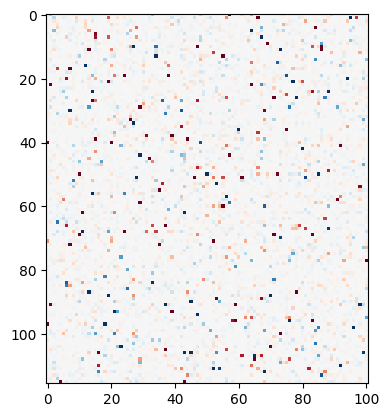

In [27]:
sort_valid_trials = np.argsort(valid_inds + valid_epoch*1000)
plt.imshow(both_controls[1][sort_valid_trials][...,1],vmin=-.5,vmax=.5,cmap='RdBu')

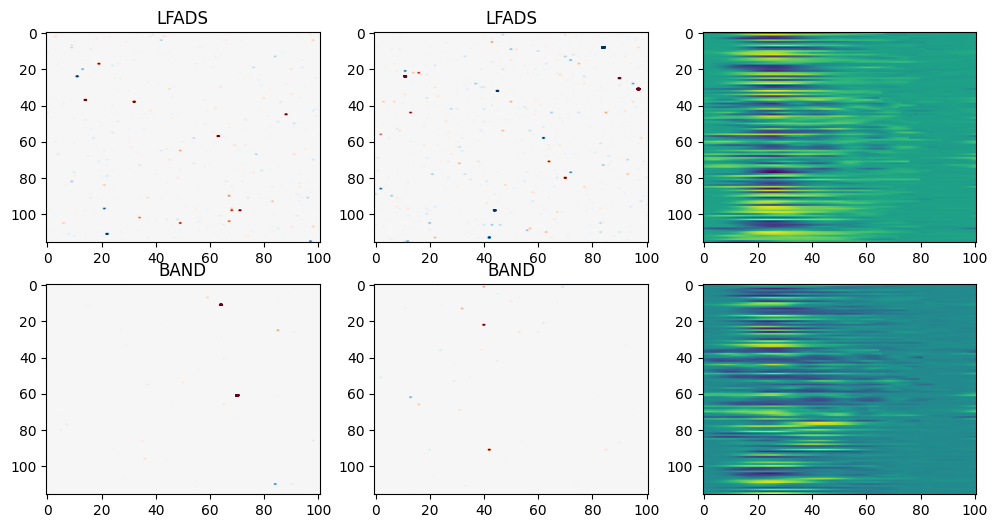

In [28]:
max_loc = np.abs(true_valid_beh).max(-1).argmax(-1)[sort_valid_trials]
# arr = np.abs(true_valid_beh).max(-1)[sort_valid_trials]
fig, ax = plt.subplots(2,3, figsize=(12,6))
for i in range(2):
    for j in range(2):
        arr = both_controls[i][sort_valid_trials][...,j]
        for k in range(arr.shape[0]):
            arr[k] = np.roll(arr[k],25-max_loc[k])
        ax[i,j].imshow(arr,vmin=-50,vmax=50,cmap='RdBu',aspect='auto')
        if i==0:
            ax[i,j].set_title('LFADS')
        else:
            ax[i,j].set_title('BAND')
    arr = true_valid_beh[sort_valid_trials][...,i]
    for k in range(arr.shape[0]):
        arr[k] = np.roll(arr[k],25-max_loc[k])
    ax[i,2].imshow(arr,aspect='auto')

In [12]:
valid_epoch

array([1, 1, 1, 0, 1, 1, 0, 2, 0, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 2, 1, 2,
       0, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2,
       1, 2, 1, 0, 1, 1, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 0, 1, 0,
       2, 2, 2, 1, 0, 1, 1, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 1, 1, 2, 2, 0,
       2, 1, 0, 1, 2, 0, 1, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 2, 0,
       0, 0, 0, 1, 2, 0])